In [261]:
import torch
from torch import nn
from torch import optim, cuda
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from timeit import default_timer as timer
import matplotlib.pyplot as plt

In [262]:
class Data(Dataset):
  def __init__(self, t):
    self.t = torch.from_numpy(t.astype(np.float32))
    self.length = np.shape(t)[0]

  def __getitem__(self, index):
    return self.t[index]
  
  def __len__(self):
    return self.length

In [263]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30, activ=torch.sin):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
        self.activ = activ
    
    def init_weights(self):
        with torch.no_grad():
            self.linear.bias.uniform_(-3.14 ,3.14)
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return self.activ(self.omega_0 * self.linear(input))

In [264]:
# class Siren(nn.Module):
#   def __init__(self, hidden_dim, output_dim, omega_0 = 10):
#     super(Siren, self).__init__()
#     self.omega_0 = omega_0
#     self.layer1 = nn.Linear(1, hidden_dim)
#     self.layer2 = nn.Linear(hidden_dim, output_dim, bias = True)
#     with torch.no_grad():
#     ]  self.layer1.weight.uniform_(-1 ,1)
#       self.layer2.weight.uniform_(100, 200)

#   def forward(self, t):
#     z = self.layer1(t)
#     N_0 = self.layer2(self.omega_0 * torch.sin(z))
#     # N_1 = self.omega_0 * self.layer2(torch.cos(z) * self.layer1.weight.reshape(1, -1))
#     return t, N_0, N_1

class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=2., activ=torch.sin):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0, activ=activ))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0, activ=activ))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0, activ=activ))
        
        self.net = nn.Sequential(*self.net)
        self.params = dict(self.net.named_parameters())
    

    def compute_output(self, inputs):
      outputs = torch.func.functional_call(self.net, self.params, inputs)
      return outputs, outputs 

    def compute_grad(self, inputs):
      gradients, values = torch.func.jacrev(self.compute_output, has_aux=True)(inputs) #use jacrev/jacfwd for multiple outputs
      gradients = torch.squeeze(gradients, -1)
      return gradients, values
    
    def compute_jac(self, inputs):
      s_gradients, values = torch.func.jacrev(self.compute_grad, has_aux=True)(inputs)
      gradients, values = self.compute_grad(inputs)
      s_gradients = torch.squeeze(s_gradients, -1)
      return s_gradients, gradients, values
    
    def forward(self, t):
        # t.requires_grad = True
        # N_0 = self.net(t)
        # ones = torch.ones_like(N_0)
        # N_1 = torch.autograd.grad(N_0, t, ones, retain_graph=True)[0]
        s_gradients, gradients, outputs = torch.vmap(self.compute_jac, in_dims=(0))(t)
        return t, outputs, gradients, s_gradients  

    # def compute_output(self, inputs):
    #   outputs = torch.func.functional_call(self.net, self.params, inputs)
    #   return outputs, outputs 

    # def grad_and_value(self, inputs):
    #   gradients, values = torch.func.jacrev(self.compute_output, has_aux=True)(inputs) #use jacrev/jacfwd for multiple outputs
    #   return gradients, values
    
    # def forward(self, t):
    #     # t.requires_grad = True
    #     # N_0 = self.net(t)
    #     # ones = torch.ones_like(N_0)
    #     # N_1 = torch.autograd.grad(N_0, t, ones, retain_graph=True)[0]
    #     gradients, outputs = torch.vmap(self.grad_and_value, in_dims=(0))(t)
    #     gradients = torch.squeeze(gradients, -1)
    #     return t, outputs, gradients      

In [265]:
# x'(t) = f(x(t),t)
def func(x, t):
  return x

In [266]:
# the true solution to the ODE
def solution_to_ODE(t):
  t = np.array(t)
  return np.exp(t)

In [267]:
random_seed = 45
torch.manual_seed(random_seed)

In [268]:
# Training and validation sets

t = np.arange(-2, 4, 0.001)

dataset = Data(t.reshape(-1, 1))

val_pct = 0.1
val_size = int(len(t) * val_pct)
train_size = len(t) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print(len(train_ds), len(val_ds))

batch_size = 200

dataloaders = {
    'train': DataLoader(train_ds, batch_size = batch_size, shuffle=True),
    'val': DataLoader(val_ds, batch_size = batch_size, shuffle=True),
}

5400 600


In [269]:
# Test data; we initialize it separately to have more freedom on where (what times) we compare
# the learnt function with the true value. Allows us to test the limits of our model.

start, end = -2, 4
t = torch.arange(start, end, 0.001)

In [270]:
train_on_gpu = torch.cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


In [271]:
def train(model, criteria, optimizer, train_loader, valid_loader, n_epochs):

  overall_start = timer()
  model.epochs = 0
  losses = []

  for epoch in range(n_epochs):
      train_loss = valid_loss = 0
      start = timer()
      for i, data in enumerate(train_loader):
        if train_on_gpu:
          data = data.cuda()
        optimizer.zero_grad()

        output = model(data)

        loss = criteria(output)
        loss.backward()

        optimizer.step()

        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * data.size(0)

        print(
              f'Epoch: {epoch}\t{100 * (i + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
              end='\r')
      else:
        model.epochs += 1
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
            for data in valid_loader:
              # Tensors to gpu
              if train_on_gpu:
                  data = data.cuda()

              # Forward pass
              output = model(data)

              # Validation loss
              loss = criteria(output)
              # Multiply average loss times the number of examples in batch
              valid_loss += loss.item() * data.size(0)

            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)
            losses.append(valid_loss)

            # Print training and validation results
            print(
                f'\nEpoch: {epoch} \tTraining Loss: {train_loss} \tValidation Loss: {valid_loss}'
            )
  # Attach the optimizer
  model.optimizer = optimizer
  # Record overall time and print out stats
  total_time = timer() - overall_start  
  
  print(
    f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
)
  return model, losses

In [272]:
def criteria(out):
  loss = nn.functional.mse_loss
  return loss(out[1] + out[0] * out[2], func(1 + out[0] * out[1], out[0]))
# loss(2*out[1] + (out[0]**2+out[0]-1)*out[2]+(out[0]**2-out[0])*out[3], func(1-out[0] + out[0]*(out[0]-1)*out[1], out[0]))

In [273]:
# in our case, we know the solution to the ODE is 4 * torch.exp(t)

def evaluate(model, test_ds):
  test_ds = test_ds.cuda()
  output = model(test_ds)
  return test_ds.detach().cpu().numpy(), (1 + output[0] * output[1]).detach().cpu().numpy()
  # times, model_outputs = [], []
  # with torch.no_grad():
  #   model.eval()
  #   for data in test_ds:
  #     data = data.view(1, 1)
  #     if train_on_gpu:
  #         data = data.cuda()
  #     output = model(data)
  #     t, N_t = output[0].cpu().item(), output[1].cpu().item()
  #     times.append(t)
  #     model_outputs.append(1+t*N_t)
  #     # 1 - t + t * (t-1)*N_t
  # return times, model_outputs

In [274]:
def plot_outputs(times, model_outputs, true_values):
  plt.scatter(times, model_outputs, label = 'model', s = 2)
  plt.scatter(times, true_values, label = 'true', s = 2)
  plt.xlabel('t')
  plt.ylabel('Function at time t')
  plt.title('Single network on [-2, 4]')
  plt.legend(loc="upper left")
  plt.show()

In [277]:
# model = Siren(10, 1, 0.002)
model = Siren(in_features=1, out_features=1, hidden_features=10, 
                  hidden_layers=10, outermost_linear=True, first_omega_0=2, hidden_omega_0=1)
if train_on_gpu:
    model = model.to('cuda')
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum=0.9)
optimizer = torch.optim.RAdam(model.parameters())

model, losses = train(model, criteria, optimizer, dataloaders['train'], dataloaders['val'], 200)

Epoch: 0	100.00% complete. 0.66 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 0.9533578775547169 	Validation Loss: 0.5820101300875345
Epoch: 1	100.00% complete. 0.63 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.5557332988138552 	Validation Loss: 0.4960189759731293
Epoch: 2	100.00% complete. 0.64 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.4877021378941006 	Validation Loss: 0.44708218177159625
Epoch: 3	100.00% complete. 0.67 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.45089948839611477 	Validation Loss: 0.4173534115155538

Epoch: 4 	Training Loss: 0.42987446542139407 	Validation Loss: 0.39666251341501874
Epoch: 5	100.00% complete. 0.64 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.4158205809416594 	Validation Loss: 0.3808234632015228
Epoch: 6	100.00% complete. 0.65 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.4049497820712902 	Validation Loss: 0.36751478910446167
Epoch: 7	100.00% complete. 0.63 seconds elapsed in epoch.
Epoch: 7 	Training Lo

4.985424


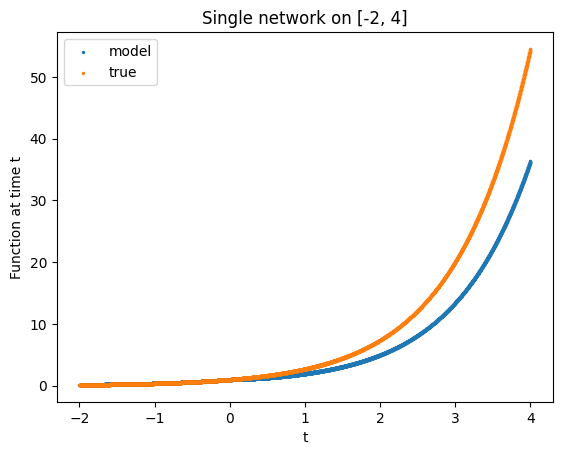

In [278]:
t = t.view(-1, 1)
times, model_outputs = evaluate(model, t)

iv = evaluate(model, torch.tensor([[2.]]).cuda())[1][0][0]
print(iv)

plot_outputs(times, model_outputs, solution_to_ODE(times))

In [257]:
model2 = Siren(in_features=1, out_features=1, hidden_features=10, 
                  hidden_layers=10, outermost_linear=True, first_omega_0=2, hidden_omega_0=1)
if train_on_gpu:
    model2 = model2.to('cuda')
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001, momentum=0.9)
optimizer = torch.optim.RAdam(model2.parameters())

def criteria2(out):
  loss = nn.functional.mse_loss
  return loss(out[1] + out[0] * out[2], func(iv + out[0] * out[1], out[0]))

model2, losses = train(model2, criteria2, optimizer, dataloaders['train'], dataloaders['val'], 400)


Epoch: 0	100.00% complete. 0.45 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 44.48727904425727 	Validation Loss: 40.884952545166016
Epoch: 1	100.00% complete. 0.64 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 40.54801834954156 	Validation Loss: 40.046409606933594
Epoch: 2	100.00% complete. 0.64 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 39.258451249864365 	Validation Loss: 38.794559478759766
Epoch: 3	100.00% complete. 0.62 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 37.5839786529541 	Validation Loss: 37.09175491333008
Epoch: 4	100.00% complete. 0.50 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 35.53159205118815 	Validation Loss: 34.75860595703125
Epoch: 5	100.00% complete. 0.41 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 33.38768715328641 	Validation Loss: 32.33657455444336

Epoch: 6 	Training Loss: 31.50580512152778 	Validation Loss: 30.236562728881836
Epoch: 7	100.00% complete. 0.43 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 29.80960093

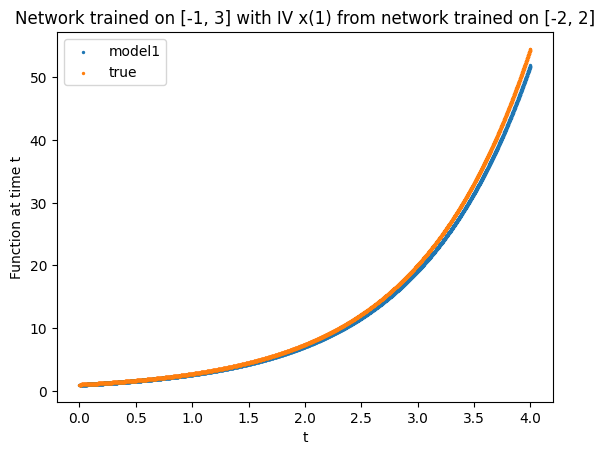

In [258]:
t = torch.arange(start, end, 0.001)
t = t.view(-1, 1)

def evaluate2(model, test_ds):
  test_ds = test_ds.cuda()
  output = model(test_ds)
  return test_ds.detach().cpu().numpy(), (iv + output[0] * output[1]).detach().cpu().numpy()

times2, model_outputs2 = evaluate2(model2, t)

plot_outputs(times2+2, model_outputs2, solution_to_ODE(times2+2))

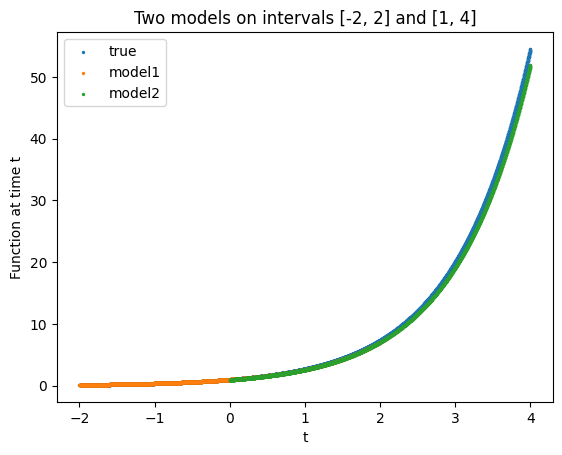

In [259]:

npt = np.arange(-2, 4, 0.001)
plt.scatter(npt, solution_to_ODE(npt), label = 'true', s = 2)
plt.scatter(times, model_outputs, label = 'model1', s = 2)
plt.scatter(times2+2, model_outputs2, label = 'model2', s = 2)

plt.xlabel('t')
plt.ylabel('Function at time t')
plt.title('Two models on intervals [-2, 2] and [1, 4]')
plt.legend(loc="upper left")
plt.show()

In [ ]:
tanh_model = Siren(in_features=1, out_features=1, hidden_features=10, 
                  hidden_layers=10, outermost_linear=True, first_omega_0=1, hidden_omega_0=1,
              activ=torch.tanh)
if train_on_gpu:
    tanh_model = tanh_model.to('cuda')

optimizer = torch.optim.RAdam(tanh_model.parameters())
tanh_model, tanh_losses = train(tanh_model, criteria, optimizer, dataloaders['train'], dataloaders['val'], 150)

Epoch: 0	100.00% complete. 0.39 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 4.824081394407484 	Validation Loss: 3.8432129621505737
Epoch: 1	100.00% complete. 0.38 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 3.9913043048646717 	Validation Loss: 3.5208297967910767
Epoch: 2	100.00% complete. 0.38 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 3.5852211316426597 	Validation Loss: 3.11076819896698
Epoch: 3	100.00% complete. 0.38 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 3.1106440093782215 	Validation Loss: 2.665130138397217
Epoch: 4	100.00% complete. 0.37 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 2.6190857887268066 	Validation Loss: 2.2228899002075195
Epoch: 5	100.00% complete. 0.37 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 2.1453793512450323 	Validation Loss: 1.8228429555892944
Epoch: 6	100.00% complete. 0.38 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 1.730408853954739 	Validation Loss: 1.4806932210922241
Epoch: 7	100.00% complete. 0.37 

In [ ]:
relu_model = Siren(in_features=1, out_features=1, hidden_features=10, 
                  hidden_layers=10, outermost_linear=True, first_omega_0=1, hidden_omega_0=1,
              activ=torch.nn.functional.relu)
if train_on_gpu:
    relu_model = relu_model.to('cuda')

optimizer = torch.optim.RAdam(relu_model.parameters())
relu_model, relu_losses = train(relu_model, criteria, optimizer, dataloaders['train'], dataloaders['val'], 150)

Epoch: 0	100.00% complete. 0.47 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.3382560809453328 	Validation Loss: 0.7287012040615082

Epoch: 1 	Training Loss: 0.6404371658960978 	Validation Loss: 0.7118608951568604
Epoch: 2	100.00% complete. 0.53 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.6304961310492622 	Validation Loss: 0.7031733393669128
Epoch: 3	100.00% complete. 0.59 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.6273783014880286 	Validation Loss: 0.6981823444366455
Epoch: 4	100.00% complete. 0.51 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.6254421969254812 	Validation Loss: 0.694939374923706

Epoch: 5 	Training Loss: 0.6219583120610979 	Validation Loss: 0.6879460513591766
Epoch: 6	100.00% complete. 0.38 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.618290450837877 	Validation Loss: 0.6825965642929077
Epoch: 7	100.00% complete. 0.39 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.6131765213277605 	Validation Loss: 0.6762919127941132
Epoc

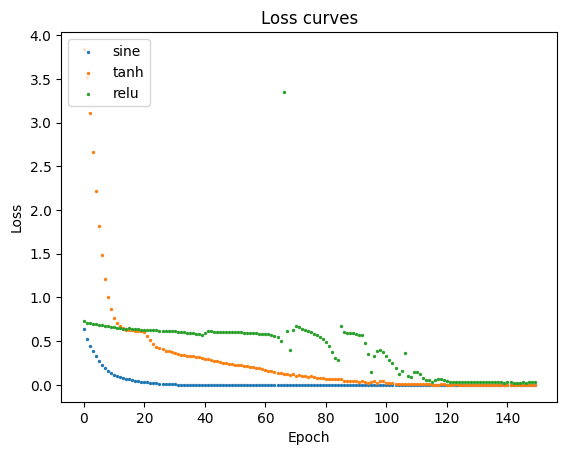

In [ ]:
# plot losses
EPOCHS = 150
plt.scatter(np.arange(EPOCHS), losses, label = 'sine', s = 2)
plt.scatter(np.arange(EPOCHS), tanh_losses, label = 'tanh', s = 2)
plt.scatter(np.arange(EPOCHS), relu_losses, label = 'relu', s = 2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curves')
plt.legend(loc="upper left")
plt.show()

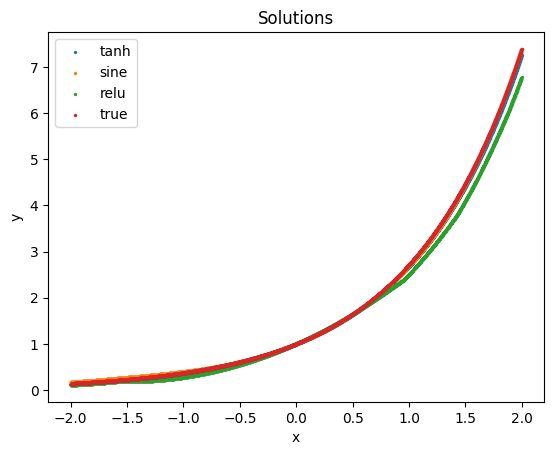

In [ ]:
times, sine_model_outputs = evaluate(model, t)
times, tanh_model_outputs = evaluate(tanh_model, t)
times, relu_model_outputs = evaluate(relu_model, t)

plt.scatter(times, tanh_model_outputs, label = 'tanh', s = 2)
plt.scatter(times, sine_model_outputs, label = 'sine', s = 2)
plt.scatter(times, relu_model_outputs, label = 'relu', s = 2)
plt.scatter(times, solution_to_ODE(times), label = 'true', s = 2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Solutions')
plt.legend(loc="upper left")
plt.show()